### Load Model Samples

In [1]:
print("strawberry")

# loss function and metrics
from trustworthai.utils.losses_and_metrics.dice_loss import DiceLossWithWeightedEmptySlices
from trustworthai.utils.losses_and_metrics.dice_loss_metric import DiceLossMetric, SsnDiceMeanMetricWrapper

# predefined training dataset
from trustworthai.utils.data_preprep.dataset_pipelines import load_data
from torch.utils.data import ConcatDataset

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.fitters.p_unet_fitter import PUNetLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# model
from trustworthai.run.model_load.load_ssn import load_ssn
from trustworthai.run.model_load.load_punet import load_p_unet
from trustworthai.run.model_load.load_deterministic import load_deterministic
from trustworthai.models.stochastic_wrappers.ssn.LowRankMVCustom import LowRankMultivariateNormalCustom
from trustworthai.models.stochastic_wrappers.ssn.ReshapedDistribution import ReshapedDistribution

# optimizer and lr scheduler
import torch

# misc
import argparse
import os
import shutil
import shlex
from collections import defaultdict
from tqdm import tqdm
import sys
from natsort import natsorted

print("banana")

strawberry
banana


In [2]:
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

In [3]:
ADNI_ds = MRI_3D_nolabels_inram_ds("/home/s2208943/ipdis/data/preprocessed_data/ADNI_300")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [01:37<00:00,  2.98it/s]


In [4]:
models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"

In [5]:
def load_best_checkpoint(model, loss, model_ckpt_folder, punet=False):
    # this is ultimately going to need to be passed a model wrapper when I implement P-Unet....
    
    # the path to the best checkpoint is stored as a single line in a txt file along with each model
    with open(os.path.join(model_ckpt_folder, "best_ckpt.txt"), "r") as f:
        ckpt_file = os.path.join(model_ckpt_folder, f.readlines()[0][:-1].split("/")[-1])
    
    if punet:
        return PUNetLitModelWrapper.load_from_checkpoint(ckpt_file, model=model, loss=loss, 
                                    logging_metric=lambda : None)
    return StandardLitModelWrapper.load_from_checkpoint(ckpt_file, model=model, loss=loss, 
                                    logging_metric=lambda : None)

In [6]:
def entropy_map_from_mean(mean, do_normalize=True):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    if mean.shape[1] == 1:
        raise ValueError("not implemented for implicit background class")
    else:
        assert mean.shape[1] == 2
    
    if do_normalize:
        probs = torch.nn.functional.softmax(mean, dim=1)
    else:
        probs = mean
    ent_map = torch.sum(-probs * torch.log(probs+1e-30), dim=1)

    return ent_map

In [7]:
def generate_means_and_samples_SSN(ds, dataset_stride=2, temp=1, num_samples=10, independent=False):
    
    rank = 15
    if independent:
        rank = 1
    
    # load model
    class TestArgs():
        def __init__(self, ):
            args_dict = {
                "dropout_p":0,
                "ssn_pre_head_layers":32,
                "ssn_rank":rank,
                "ssn_epsilon":1e-5,
                "dice_empty_slice_weight":0.5,
                "ssn_mc_samples":10,
                "dice_factor":5,
                "xent_factor":0.01,
                "ssn_sample_dice_coeff":0.05
            }

            for key, value in args_dict.items():
                setattr(self, key, value)

    args = TestArgs()

    model_raw, loss = load_ssn(args)
    model_raw = model_raw.cuda()
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    if independent:
        model_base_name = "ssn_ind_32_cross_validate_"
    else:
        model_base_name = "ssn_cross_validate_32_"
    ensemble_element = 1

    means = []
    samples = []

    test_datasets = []

    for split in range(1):
        test_ds_clin = ds
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))


        if independent:
            model_name = model_base_name + f"split{split}/"
        else:
            model_name = model_base_name + f"split{split}_ens{ensemble_element}/"
        model_path = models_folder + model_name

        model = load_best_checkpoint(model_raw, loss, model_path)
        model.eval()

        dataskip = dataset_stride
        for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
            if i % dataskip == 0:
                x = data
                with torch.no_grad():
                    mean, sample = model.mean_and_sample(x.swapaxes(0,1).cuda(), num_samples=num_samples, temperature=temp)
                    means.append(mean.cpu())
                    samples.append(sample.cpu())

    return means, samples, ConcatDataset(test_datasets)

In [8]:
def generate_means_and_samples_SSN_Ens_Efficient(ds, dataset_stride=2, temp=1, num_samples=10, use_updated_scores=False):
    # load model
    class TestArgs():
        def __init__(self, ):
            args_dict = {
                "dropout_p":0,
                "ssn_pre_head_layers":32,
                "ssn_rank":15,
                "ssn_epsilon":1e-5,
                "dice_empty_slice_weight":0.5,
                "ssn_mc_samples":10,
                "dice_factor":5,
                "xent_factor":0.01,
                "ssn_sample_dice_coeff":0.05
            }

            for key, value in args_dict.items():
                setattr(self, key, value)

    args = TestArgs()

    model_raw, loss = load_ssn(args)
    model_raw = model_raw.cuda()
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    model_base_name = "ssn_cross_validate_32_"

    means = []
    samples = []

    test_datasets = []

    for split in range(1):
        model_outs = defaultdict(lambda : {'means':[], 'samples':[]})
        
        test_ds_clin = ds
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))


        for ens in range(10):
            model_name = model_base_name + f"split{split}_ens{ens}/"
            model_path = models_folder + model_name

            # with open(model_path + "best_ckpt.txt") as f:
            #     lines = f.readlines()
            #     args_lines = [l[:-1].split(": ") for l in lines[1:]]
            #     args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            #     args_line = " ".join(args_lines)
            #     parser = construct_parser()
            #     args = parser.parse_args(shlex.split(args_line))

            # load the model
            model = load_best_checkpoint(model_raw, loss, model_path)
            model.eval()


            dataskip = dataset_stride
            # means = []
            # samples = []
            for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
                if i % dataskip == 0:
                    x = data
                    with torch.no_grad():
                        mean, sample = model.mean_and_sample(x.swapaxes(0,1).cuda(), num_samples=num_samples // 10, temperature=temp, symmetric=False)

                        model_outs[i]['means'].append(mean.cpu())
                        model_outs[i]['samples'].append(sample.cpu())

        for idx in tqdm(model_outs.keys(), position=0, leave=True):
            means.append(torch.stack(model_outs[idx]['means'], dim=0).mean(dim=0))
            samples.append(torch.cat(model_outs[idx]['samples'], dim=0))

    return means, samples, ConcatDataset(test_datasets)

In [9]:
def generate_means_and_samples_SSN_Ens_Mean(ds, dataset_stride=2, temp=1, num_samples=10, components=10, use_updated_scores=False):
    
    test_datasets = []

    # load model
    class TestArgs():
        def __init__(self, ):
            args_dict = {
                "dropout_p":0,
                "ssn_pre_head_layers":32,
                "ssn_rank":15,
                "ssn_epsilon":1e-5,
                "dice_empty_slice_weight":0.5,
                "ssn_mc_samples":10,
                "dice_factor":5,
                "xent_factor":0.01,
                "ssn_sample_dice_coeff":0.05
            }

            for key, value in args_dict.items():
                setattr(self, key, value)

    args = TestArgs()

    model_raw, loss = load_ssn(args)
    model_raw = model_raw.cuda()
    model_raw.return_cpu_dist = True

    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    model_base_name = "ssn_cross_validate_32_"

    means = []
    samples = []

    for split in range(1):
        # load specific data split
        test_ds_clin = ds
        test_datasets.append(test_ds_clin)
        # print("size: ", len(test_ds_clin))

        dataskip = dataset_stride

        for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
            if i % dataskip == 0:
                x = data.swapaxes(0,1).cuda()
                distribution_means = []
                distribution_cov_diags = []
                distribution_cov_factors = []
                distribution_event_shapes = []

                for ens in range(components):
                    # print(ens)
                    model_name = model_base_name + f"split{split}_ens{ens}/"
                    model_path = models_folder + model_name
                    model = load_best_checkpoint(model_raw, loss, model_path)
                    model.eval()

                    with torch.no_grad():
                        mean, cov_diag, cov_factor, event_shape = model(x)
                    distribution_means.append(mean.cpu())
                    distribution_cov_diags.append(cov_diag.cpu())
                    distribution_cov_factors.append(cov_factor.cpu())
                    distribution_event_shapes.append(event_shape)

                # print(distribution_means[0].shape)

                distribution_means = torch.stack(distribution_means, dim=0).mean(dim=0)
                distribution_cov_diags = torch.stack(distribution_cov_diags, dim=0).mean(dim=0)
                distribution_cov_factors = torch.stack(distribution_cov_factors, dim=0).mean(dim=0)

                # print(distribution_means.shape)

                dist = LowRankMultivariateNormalCustom(distribution_means, distribution_cov_factors, distribution_cov_diags)
                dist = ReshapedDistribution(dist, distribution_event_shapes[0])

                means.append((dist.mean / temp).cpu())
                samples.append((model_raw._samples_from_dist(dist, num_samples=num_samples)/temp).cpu())

    return means, samples, ConcatDataset(test_datasets)

In [10]:
import matplotlib.pyplot as plt
from trustworthai.utils.uncertainty_maps.entropy_map import entropy_map_from_samples
from trustworthai.utils.plotting.saving_plots import save, imsave
from trustworthai.utils.print_and_write_func import print_and_write
import pandas as pd

In [11]:
#samples[0].shape

In [12]:
from torch.utils.data import Dataset

class LimitedSizeDataset(Dataset):
    def __init__(self, base_dataset, start, end):
        super().__init__()
        self.base_dataset = base_dataset
        self.start = start
        self.end = end
        
    def __len__(self):
        return self.end - self.start
    
    def __getitem__(self, idx):
        if idx + self.start >= self.end:
            raise IndexError
        return self.base_dataset[idx + self.start]

In [13]:
part = 3
start = 0 + (70 * part)
end = 301#70 + (70 * part)

In [14]:
ds = LimitedSizeDataset(ADNI_ds, start=start, end=end)

In [15]:
IDs = ADNI_ds.getIDs()[start:end]

In [16]:
len(ds)

91

In [17]:
stride = 1

In [18]:
means, samples, test_datasets = generate_means_and_samples_SSN_Ens_Efficient(ds, dataset_stride=stride, temp=1, num_samples=10)

size:  91


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:23<00:00,  3.43it/s]


In [19]:
len(means), len(samples)

(80, 80)

In [20]:
# softmax entropy
# ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=True) for scan_index in range(len(means))]

# evidential
# ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=False) for scan_index in range(len(means))]

# other methods
ent_maps = [entropy_map_from_samples(samples[scan_index]) for scan_index in range(len(means))]

In [21]:
test_datasets[0].shape

torch.Size([3, 58, 220, 220])

(-0.5, 219.5, 219.5, -0.5)

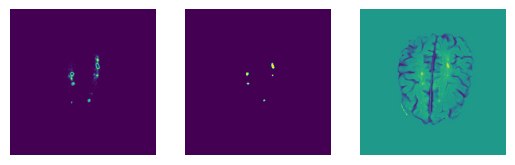

In [22]:
scan_id = 0
islice = 40
plt.subplot(1,3,1)
plt.imshow(ent_maps[scan_id][islice]); plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(means[scan_id][islice].argmax(dim=0)); plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(test_datasets[scan_id][0][islice]); plt.axis('off')

In [23]:
import scipy

In [24]:
### recording the sample diversity of volumes. (I can get range, IQR, coefficient of variation, skewness)
results = []
for i, s in tqdm(enumerate(samples), position=0, leave=True, total=len(samples)):
    s_pred = s.cuda().argmax(dim=2)
    slices = s.shape[1]
    num_samples = s.shape[0]
    s_pred = s.argmax(dim=2)
    slice_vols = s_pred.sum(dim=(-2, -1))
    sorted_slice_vols = torch.sort(slice_vols, dim=0)[1]
    sorted_samples = torch.zeros(s_pred.shape)
    for j in range(num_samples):
        sorted_samples[j] = s_pred[sorted_slice_vols[j], torch.arange(0, slices, 1)]
    sorted_sample_volumes = sorted_samples.sum(dim=(-3, -2, -1)).cpu()
    
    assert torch.equal(sorted_sample_volumes, torch.sort(sorted_sample_volumes)[0])
    
    mean_vol = means[i].cuda().argmax(dim=1).sum(dim=(-3, -2, -1)).item()
    
    ss_vds = ((sorted_sample_volumes - mean_vol).abs() / mean_vol) * 100
    
    results.append([
        sorted_sample_volumes.std().item(),
        scipy.stats.iqr(sorted_sample_volumes),
        scipy.stats.skew(sorted_sample_volumes),
        
        ss_vds.std().item(),
        scipy.stats.iqr(ss_vds),
        scipy.stats.skew(ss_vds),
        
    ])
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [05:28<00:00,  4.10s/it]


In [25]:
import pandas as pd
df = {
    "ID":IDs,
    "sample_div_std":[r[0] for r in results],
    "sample_div_IQR":[r[1] for r in results],
    "sample_div_skew":[r[2] for r in results],
    "sample_div_vd_std":[r[3] for r in results],
    "sample_div_vd_IQR":[r[4] for r in results],
    "sample_div_vd_skew":[r[5] for r in results],
}

df = pd.DataFrame(df)
df.to_csv(f"umap_data_spreadsheets/ADNI/sample_div_data_SSN_Ens_part_{part + 1}.csv")